# Continuous Probabilistic Methods: Outlier Detection

In [345]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

## 1. Using lemonade.csv dataset and focusing on continuous variables:

In [273]:
# read in the dataset
df = pd.read_csv('https://gist.githubusercontent.com/ryanorsinger/' \
                 '19bc7eccd6279661bd13307026628ace/raw/e4b5d6787015a4' \
                 '782f96cad6d1d62a8bdbac54c7/lemonade.csv')

Let's take a look at our data and see what the story it tells.

In [285]:
print(f'There are {df.shape[0]} rows and {df.shape[1]} columns')
df.head()

There are 365 rows and 7 columns


,Date,Day,Temperature,Rainfall,Flyers,Price,Sales
0,1/1/17,Sunday,27.0,2.00,15,0.5,10
1,1/2/17,Monday,28.9,1.33,15,0.5,13
2,1/3/17,Tuesday,34.5,1.33,27,0.5,15
3,1/4/17,Wednesday,44.1,1.05,28,0.5,17
4,1/5/17,Thursday,42.4,1.00,33,0.5,18


In [276]:
df.describe()

,Temperature,Rainfall,Flyers,Price,Sales
count,365.000000,365.000000,365.000000,365.0,365.000000
mean,61.224658,0.825973,40.104110,0.5,27.865753
std,18.085892,0.273890,13.786445,0.0,30.948132
min,15.100000,0.400000,-38.000000,0.5,7.000000
25%,49.700000,0.650000,31.000000,0.5,20.000000
50%,61.100000,0.740000,39.000000,0.5,25.000000
75%,71.700000,0.910000,49.000000,0.5,30.000000
max,212.000000,2.500000,80.000000,0.5,534.000000


In [286]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         365 non-null    object 
 1   Day          365 non-null    object 
 2   Temperature  365 non-null    float64
 3   Rainfall     365 non-null    float64
 4   Flyers       365 non-null    int64  
 5   Price        365 non-null    float64
 6   Sales        365 non-null    int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 20.1+ KB


## 1a.
Use the IQR Range Rule and the upper and lower bounds to identify the lower outliers of each column of `lemonade.csv`, using the multiplier of 1.5.
> Do these lower outliers make sense? Which outliers should be kept?

Let's create a function to detect outliers for us!

In [287]:
## Refactor into function named: get_lower_and_upper_bounds()

def outliers(df, multiplier=1.5):
    '''
    Accepts a dataframe and returns the outliers for each column as a
    list of dataframes

    parameters
    ----------
    df : pandas dataframe
    
    multiplier : numeric data type, default 1.5
        The multiplier sets the upper and lower range
        to classify observations as outliers.
        
    returns
    -------
    returns a list of dataframes with outlier statistics for each numeric column.
    '''
    df = df.select_dtypes(np.number)
    columns = df.columns.to_list()
    df_outliers = []
    feature_bounds = pd.DataFrame(index=['lower_bound',
                                         'upper_bound',
                                         'num_of_lower_outliers',
                                         'num_of_upper_outliers'])
    
    for column in df.columns:
        feature = df[column]
        column_Q3 = feature.quantile(.75)
        column_Q1 = feature.quantile(.25)
        column_iqr = column_Q3 - column_Q1

        upper_bound = column_Q3 + (multiplier*column_iqr)
        lower_bound = column_Q1 - (multiplier*column_iqr)
        
        upper_outliers = pd.DataFrame(feature[feature > upper_bound])
        lower_outliers = pd.DataFrame(feature[feature < lower_bound])
        col_outliers = pd.concat([upper_outliers, lower_outliers]).sort_values(by=f'{column}').reset_index(drop=True)
        df_outliers.append(col_outliers)
        feature_bounds[f'{column}'] = [lower_bound,
                                       upper_bound,
                                       lower_outliers.count()[0],
                                       upper_outliers.count()[0]]
    return df_outliers, feature_bounds

def outlier_counts(df):
    '''
    Accepts a list of dataframes and returns the number of outliers in 
    '''
    for i in range(len(df_outliers)):
        print(df_outliers[i].columns[0])
        print(f'{df_outliers[i].count()[0]} outliers')
        print(f'Index: {i}', end='\n\n')

In [288]:
df_outliers, df_outlier_bounds = outliers(df)

In [289]:
df_outlier_bounds

,Temperature,Rainfall,Flyers,Price,Sales
lower_bound,16.7,0.26,4.0,0.5,5.0
upper_bound,104.7,1.30,76.0,0.5,45.0
num_of_lower_outliers,1.0,0.00,1.0,0.0,0.0
num_of_upper_outliers,1.0,28.00,2.0,0.0,4.0


In [290]:
outlier_counts(df_outliers)

Temperature
2 outliers
Index: 0

Rainfall
28 outliers
Index: 1

Flyers
3 outliers
Index: 2

Price
0 outliers
Index: 3

Sales
4 outliers
Index: 4



## Lower Outliers : Q1 - (1.5 * IQR)
Now that we've got a function to collect the outliers from our dataframe, let's take a look at features with  __lower bound__ outliers: `Temperature` and `Flyers`.


__Summary__:
Keep lower bound outliers for `Temperature` and `Flyers`.

---

### `Temperature`
One outlier falls below the lower bound of 16.7 degrees <strong>Fahrenheit</strong> : 15.1 degrees <strong>Fahrenheit</strong>. Depending on the geographical location, season and historical recorded temperatures, this may not be an anomoly.

<br>
<strong>Keep this observation.</strong>

In [291]:
df_outliers[0]

,Temperature
0,15.1
1,212.0


### `Flyers`
There is one lower bound outlier for `Flyers`: -38. Flyers could have been returned by customers for a discount, taken down by local HOA, or taken on a wild adventure by the wind.

<strong>Drop this observation or keep it and document what caused it.</strong>

In [292]:
df_outliers[2]

,Flyers
0,-38
1,77
2,80


---
## Upper Outliers : Q3 + (1.5 * IQR)
Now that we've addressed and documented our lower outliers, let's take a look at the <strong>upper outliers</strong>: `Temperature`, `Rainfall`, `Flyers`, and `Sales.`

<strong>Summary</strong>: Keep upper bound outliers for `Rainfall`, `Flyers`, and `Sales`. Correct and document `Temperature` outlier.

---

### `Temperature`

Well. We have an outlier of 212 degrees Fahrenheit. The temperature could have been 112 but was entered as 212. Classic entry error. We can use the `Date` column from our dataset and validate our recorded temperature with the historical temperature on that date.

<strong>If we can correct the temperature for this day, let's correct and document the change. Otherwise let's drop this value.</strong>

In [293]:
df_outliers[0]

,Temperature
0,15.1
1,212.0


### `Rainfall`
Similar to `Temperature` outliers, `Rainfall` outliers depend on geographical location, season and historical recorded temperatures.

<strong>Keep all observations</strong>

In [310]:
print('Rainfall Upper Bound: {}'.format(df_outlier_bounds['Rainfall'][1]))
df_outliers[1]

Rainfall Upper Bound: 1.3


,Rainfall
0,1.33
1,1.33
2,1.33
3,1.33
4,1.33
5,1.33
6,1.33
7,1.33
8,1.33
9,1.43


### `Flyers`

These two days are slightly outside of the upper bound. The days these Flyer values were recorded could have been to:
- Spread the word about the Lemonade Stand opening - Local community
- Once the initial word got out, posted flyers in - Neighborhoods, Schools

<strong>Keep these observations</strong>

In [315]:
print('Flyers Upper Bound: {}'.format(df_outlier_bounds['Flyers'][1]))
df_outliers[2]

Rainfall Upper Bound: 76.0


,Flyers
0,-38
1,77
2,80


### `Sales`
These values may represent days when the temperature was hot, success flyer campaign/word of mouth in a neighborhood.

<strong>Keep these observations</strong>

In [316]:
print('Sales Upper Bound: {}'.format(df_outlier_bounds['Sales'][1]))
df_outliers[4]

Sales Upper Bound: 45.0


,Sales
0,143
1,158
2,235
3,534


## 1b.
Using the multiplier of 3, IQR Range Rule, and the lower and upper bounds, identify the outliers below the lower bound in each colum of `lemonade.csv`.
>Do these lower outliers make sense? Which outliers should be kept?

In [317]:
df_outliers, df_outlier_bounds = outliers(df, multiplier=3)

In [319]:
df_outlier_bounds

,Temperature,Rainfall,Flyers,Price,Sales
lower_bound,-16.3,-0.13,-23.0,0.5,-10.0
upper_bound,137.7,1.69,103.0,0.5,60.0
num_of_lower_outliers,0.0,0.00,1.0,0.0,0.0
num_of_upper_outliers,1.0,4.00,0.0,0.0,4.0


## Lower Outliers : Q1 - (3 * IQR)

We have one lower outlier in `Flyers`. I'll repeat what I've said above.
> Drop this observation or keep it and document what caused it.

The lower_bounds do not make sense for `Rainfall`. It either rains or is doesn't (recorded as 0). `Temperature` needs to be compared with historical temperature to see if it's even possible to have a negative temperature at a given time of year. Negative `Sales` could represent a refund/on the house lemonade? 

### `Flyers`

In [322]:
print('Flyers Lower Bound: {}'.format(df_outlier_bounds['Flyers'][0]))
df_outliers[2]

Flyers Lower Bound: -23.0


,Flyers
0,-38


## Upper Outliers : Q3 + (3 * IQR)

I'll repeat what I've documented above using 1.5 as the multiplier:
> "Summary: Keep upper bound outliers for `Rainfall`, `Flyers`, and `Sales`. Correct and document `Temperature` outlier."

## 2. Identify if any columns in lemonade.csv are normally distributed. For normally distributed columns:
Use a 2 sigma decision rule to isolate the outliers.
    Do these make sense?
    Should certain outliers be kept or removed?

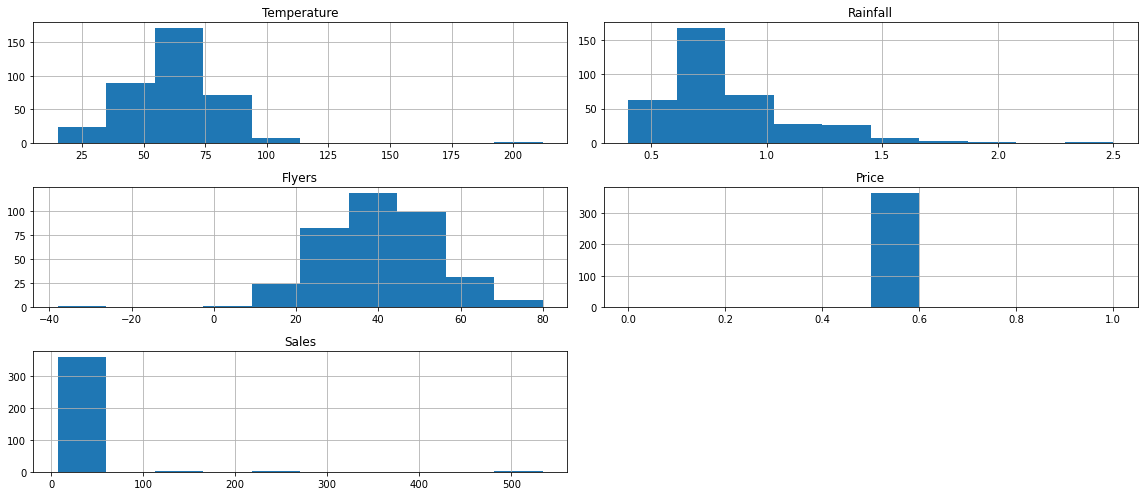

In [323]:
df.hist(figsize=(16, 7))
plt.tight_layout();

Temperature


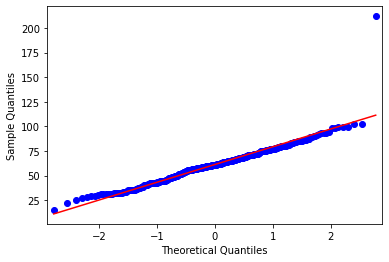

Rainfall


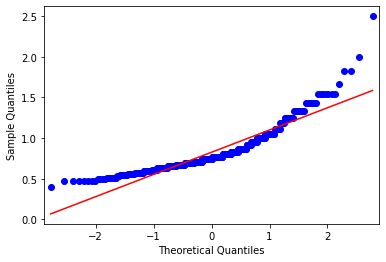

Flyers


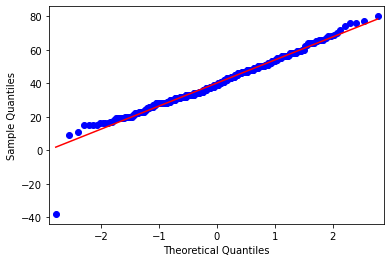

Price


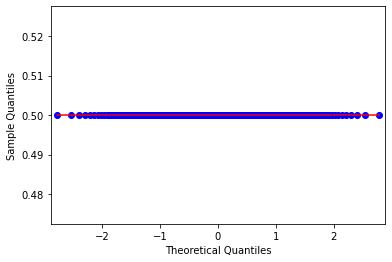

Sales


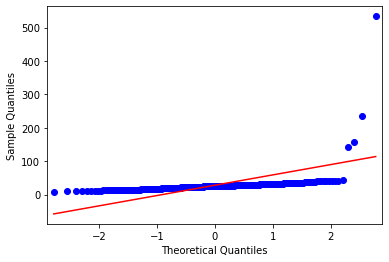

In [344]:
from statsmodels.graphics.gofplots import qqplot
# seed the random number generator

for column in df.select_dtypes(np.number):
    qqplot(df[column], line='s')
    print(f'{column}')
    plt.show()

In [352]:
for column in df.select_dtypes(np.number):
    stat, p = stats.shapiro(df[column])
    print(column)
    print('Statistics=%.3f, p=%.3f' % (stat, p))

    alpha = 0.05
    if p > alpha:
        print('Sample looks normally distributed (fail to reject H0)', end='\n\n')
    else:
        print('Sample does not normally distributed (reject H0)', end='\n\n')

Temperature
Statistics=0.915, p=0.000
Sample does not normally distributed (reject H0)

Rainfall
Statistics=0.851, p=0.000
Sample does not normally distributed (reject H0)

Flyers
Statistics=0.975, p=0.000
Sample does not normally distributed (reject H0)

Price
Statistics=1.000, p=1.000
Sample looks normally distributed (fail to reject H0)

Sales
Statistics=0.207, p=0.000
Sample does not normally distributed (reject H0)



## 3. Now use a 3 sigma decision rule to isolate the outliers in the normally distributed columns from lemonade.csv